In [1]:
import numpy as numpy
import pandas as pd
import math 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#create function to identify which galaxy an x-ray flash or variable star is in
#home function (because it finds star's home)
def home(ax, ay, bx, by, length):
    closestradius=1e12
    for counter in range (0, length):
        #radius is distance between star/flash and galaxy
        radius=math.sqrt((ax[counter]-bx)**2+(ay[counter]-by)**2)
        if radius< closestradius:
            closestradius=radius 
            #value is the identifier of the galaxy we have found the star/flash to be closest to
            value=counter
    return value

#read in data from AllGalaxies
gData = pd.read_csv("AllGalaxies.csv", index_col="Name")
gx = gData['X'].to_numpy() #x coord of galaxy 
gy = gData['Y'].to_numpy()
gv=gData['RadialVelocity'].to_numpy()
length=len(gx)
gdlist =[0.0]*length
gddlist =[0.0]*length

#read in data from Mag.csv to a panda and then into numpy arrays
vData = pd.read_csv("Far.csv", index_col="Name")
vx = vData['X'].to_numpy() #x-coord of variable star
vy = vData['Y'].to_numpy()
vdlist=vData['Distance'].to_numpy() #distance of star from NewEarth 
vdlist=numpy.true_divide(vdlist, 1000000) #pc to Mpc
vddlist=vData['dDistance'].to_numpy() #uncertainty in vdlist
vddlist=numpy.true_divide(vddlist, 1000000)

#read in data from x-ray flashes
flashData = pd.read_csv("Flash_Data.csv", index_col="Name")
fx = flashData['X'].to_numpy() #x cood of flash 
fy = flashData['Y'].to_numpy()
fp=flashData['PhotonCount'].to_numpy()
n=len(fx)
fxlist=[0.0]*n #1/d^2 list for all x-ray flashes
fdxlist=[0.0]*n #uncertainty in fxlist
fdlist =[0.0]*n #distance for all xray flashes
fddlist=[0.0]*n  #uncertainty in distanec for all xray flashes

In [2]:
#Monte Carlo 
def monte_carlo(xdata, xuncs, ydata, yuncs, iterations):

    # initialise arrays to store our data in
    grads = numpy.zeros(iterations)
    yints = numpy.zeros(iterations)
    x_rand = numpy.zeros(len(xdata))
    y_rand = numpy.zeros(len(xdata))
    
    # if our uncertainty is a scalar, make it an array with N times that value (N being the length of our data array)
    if numpy.size(xuncs) == 1:
        xuncs = numpy.ones(len(xdata)) * xuncs
    if numpy.size(yuncs) == 1:
        yuncs = numpy.ones(len(ydata)) * yuncs
    
    # now to perform n=iterations random samples of our data distributions
    for i in range(iterations):
        for j in range(len(xdata)):
            # generate a random normal variable for each of our XY data points
            x_rand[j] = numpy.random.normal(xdata[j], xuncs[j])
            y_rand[j] = numpy.random.normal(ydata[j], yuncs[j])
            
            
        # now fit a line to our random data. A 1-dimensional polynomial is just a straight line!
        grads[i], yints[i] = numpy.polyfit(x_rand, y_rand, 1)
        
    
    # now get the statistics of our *iterations* number of trendline parameters
    meangrad = numpy.mean(grads[:i])
    SDgrad = numpy.std(grads[:i])
    meanyint = numpy.mean(yints[:i])
    SDyint = numpy.std(yints[:i])
    return numpy.array([meangrad, SDgrad, meanyint, SDyint])

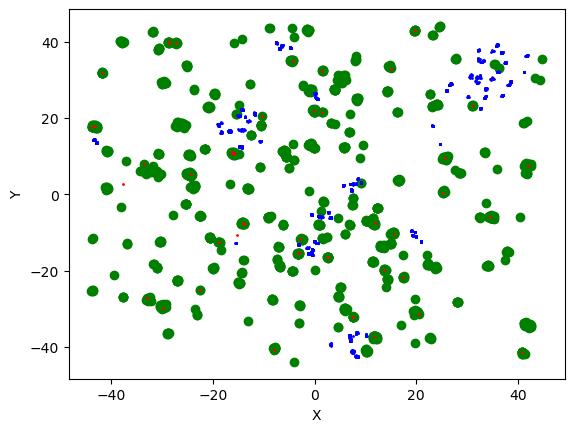

In [3]:
#plot of galaxy, variable star and x-ray flash
plt.plot(gx,gy,color='green', marker='o', linestyle='none')
plt.plot(fx,fy,color='red', marker='o', linestyle='none', markersize=1)
plt.plot(vx,vy,color='blue', marker='o', linestyle='none', markersize=1)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [4]:
#identify a home galaxy for each of the variable star
l=len(vx)

#repeat for every star
for star in range(0, l):
    #get coords of star
    bx=vx[star]
    by=vy[star]
    #find home galaxy
    answer=home(gx, gy, bx, by, length) #returns index of home galaxy 
    gdlist[answer]=vdlist[star]
    gddlist[answer]=vddlist[star]

In [5]:
#identify k closest flashes
k=7
highestFlashes=flashData.nlargest(k,'PhotonCount')

#numpy arrays hfx means x co-ord of highest flash 
hfx = highestFlashes['X'].to_numpy()
hfy = highestFlashes['Y'].to_numpy()
hfi=highestFlashes['I'].to_numpy()
photonCountList = highestFlashes['PhotonCount'].to_numpy()
hfdlist =[0]*k #high flash distance list
hfddlist =[0]*k  #uncertainty in high flash distance list 


In [6]:
#identify a home galaxy for each of the highest flashes

#repeat for every flash 
for i in range(0, k):
    #get coords of x-ray flash
    bx=hfx[i]
    by=hfy[i]
    #find home galaxy
    identifier=home(gx, gy, bx, by, length) #returns index of home galaxy 

    #distance of the xray flash= distance of closest galaxy 
    hfdlist[i]=gdlist[identifier]
    hfddlist[i]=gddlist[identifier]

print(hfdlist)
print(hfddlist)

 

[0.0, 0.0, 0.012033752686647482, 0.014295783319736131, 0.02315638567803066, 0.02822036757964849, 0.024433880393813077]
[0.0, 0.0, 0.002143421995448548, 0.0026047121524266597, 0.0042280282474975225, 0.004892392687678213, 0.00450714770524655]


In [7]:
#plot distance versus photon count for highest x-ray flashes
graphdf = pd.DataFrame(data=[hfdlist, photonCountList, hfddlist], index=['hfdlist', 'plist','hfddlist' ]).T
graphdf.query('hfdlist>0', inplace=True)
print(graphdf)

dlist= graphdf['hfdlist'].to_numpy()
ddlist = graphdf['hfddlist'].to_numpy()
plist = graphdf['plist'].to_numpy() 

z=len(dlist)
qlist=[0.0]*z
dqlist=[0.0]*z
xlist=[0.0]*z
dxlist=[0.0]*z

qlist=dlist**2
dqlist=ddlist*2*dlist

xlist=1/qlist
dxlist=(dqlist/qlist)*xlist

print(xlist)
print(dxlist)

    hfdlist     plist  hfddlist
2  0.012034  335458.0  0.002143
3  0.014296  197713.0  0.002605
4  0.023156   84349.0  0.004228
5  0.028220   84315.0  0.004892
6  0.024434   82567.0  0.004507
[6905.5430401  4893.0999386  1864.91246352 1255.66753968 1675.0011623 ]
[2459.99618375 1783.05960409  681.01323622  435.37481728  617.95159207]


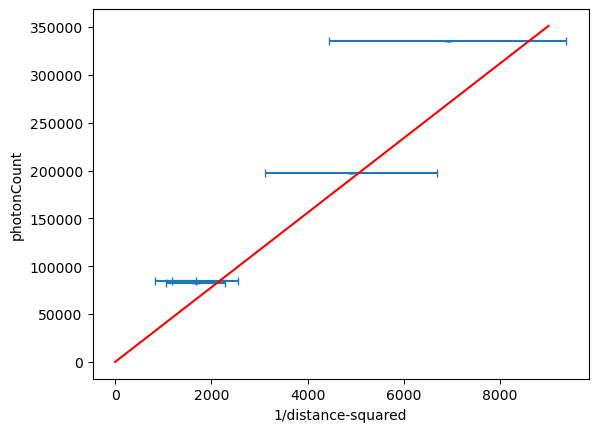

In [8]:
#plot line and find gradient m

dp=0 #no uncertainty in photon count

fit=monte_carlo(xlist, dxlist, plist, dp, 10000)

x=numpy.linspace(0, 9000, 500)
y=x*fit[0]

plt.errorbar(xlist, plist, dp, dxlist, fmt='o', markersize=1, capsize=3)
plt.plot(x,y,'-r')
plt.xlabel("1/distance-squared")
plt.ylabel("photonCount")
plt.show()

In [9]:
#new flashData column distance 
fxlist= fp/fit[0]
fdxlist= fxlist*(fit[1]/fit[0])

rlist=numpy.sqrt(fxlist)
drlist=fdxlist/(2*rlist)

fdlist=1/rlist
fddlist=(drlist/rlist)*fdlist

newgdlist=[0.0]*length
newgddlist=[0.0]*length #uncertainty in galaxy distance

#find galaxy for each flash 
for q in range(0, n):
    #get coords of x-ray flash
    bx=fx[q]
    by=fy[q]
    #find home galaxy
    p=home(gx, gy, bx, by, length) #returns index of home galaxy 

    #save distance for each galaxy 
    newgdlist[p]=fdlist[q]
    newgddlist[p]=fddlist[q]

#filter galaxies with distance greater than 0
gData['Distance'] = newgdlist
gData['dDistance'] = newgddlist
finalData=gData.query('Distance>0.05')
print(len(finalData.index))


46


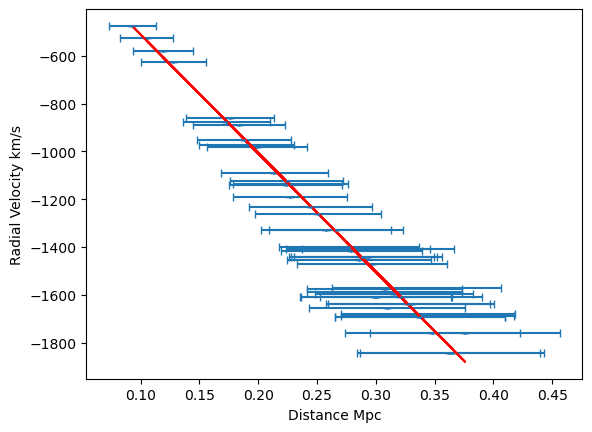

The hubble constant is: -4962.83 +/- 92.42
The y-int is: -15.13 +/- 25.5


In [12]:

DistanceList = finalData['Distance'].to_numpy()
dDistanceList = finalData['dDistance'].to_numpy()
VelocityList = finalData['RadialVelocity'].to_numpy()
dVelocityList=[0.1]*len(VelocityList)

m=-4962.83
dm=92.42
c=-15.13
dc=25.50

y=(DistanceList*m)+c

plt.errorbar(DistanceList,VelocityList, dVelocityList, dDistanceList, fmt='o', markersize=1, capsize=3)
plt.plot(DistanceList, y,'-r')
plt.xlabel("Distance Mpc")
plt.ylabel("Radial Velocity km/s")
plt.show()

print("The hubble constant is:", m, "+/-", dm)
print("The y-int is:", c, "+/-", dc)
